In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import scipy
import keras
import glob

2026-02-15 07:15:35.920017: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771157736.136214  113580 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771157736.200557  113580 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771157736.696150  113580 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771157736.696182  113580 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771157736.696184  113580 computation_placer.cc:177] computation placer alr

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
root_path = "./data"

data_input = np.load(os.path.join(root_path, 'run0001_halo.npy'))
data_output = np.load(os.path.join(root_path, 'run0001_dm.npy'))

len(data_input)

128

In [4]:
data_input

array([[[133.72241 ,  36.034256,  -1.      , ...,  -1.      ,
          -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      , ...,  -1.      ,
          -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      , ...,  -1.      ,
          -1.      ,  -1.      ],
        ...,
        [ -1.      ,  -1.      ,  -1.      , ...,  -1.      ,
          -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      , ...,  -1.      ,
          -1.      ,  -1.      ],
        [216.34586 ,  58.746864,  -1.      , ...,  -1.      ,
          -1.      ,  -1.      ]],

       [[ -1.      ,  -1.      ,  -1.      , ...,  -1.      ,
          -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      , ...,  -1.      ,
          -1.      ,  -1.      ],
        [ -1.      ,  -1.      ,  -1.      , ...,  -1.      ,
          -1.      ,  -1.      ],
        ...,
        [ -1.      ,  -1.      ,  -1.      , ...,  -1.      ,
          -1.      ,  -1.      ],
        [ -1

Number of Candidate Galaxies: 5590


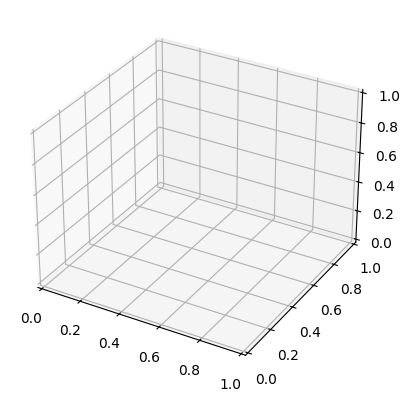

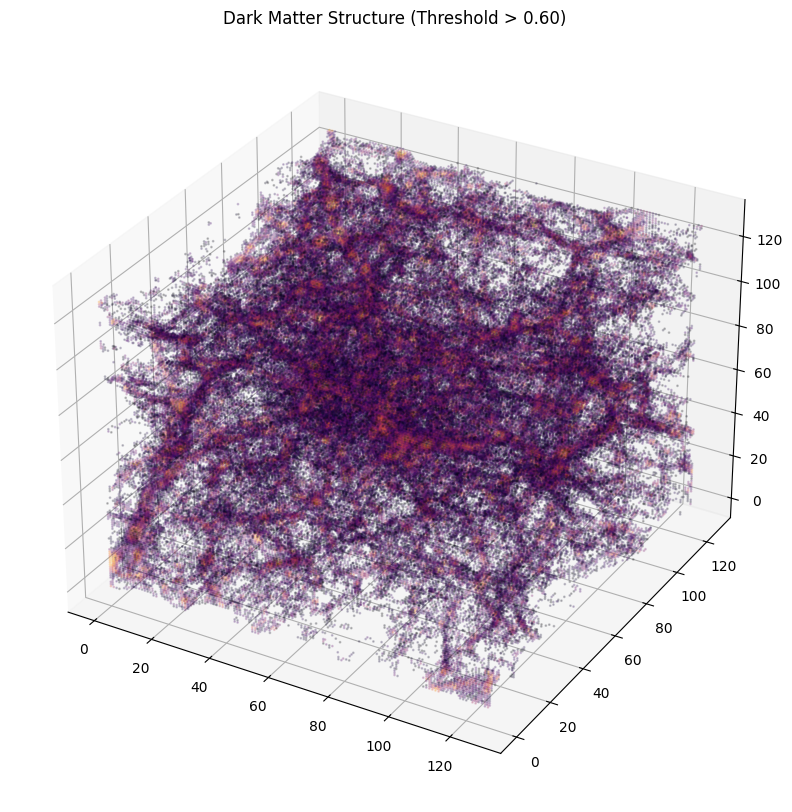

In [5]:
fig = plt.figure()
ax = plt.axes(projection='3d')
threshold = np.percentile(data_output, 90) 
mask = data_output > threshold

values = data_output[mask]
z,y,x = np.where(mask)
labeled_array, num_galaxies = scipy.ndimage.label(mask, structure=np.ones((3,3,3)))

print(f"Number of Candidate Galaxies: {num_galaxies}")
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=np.log2(values), cmap='inferno', s=1, alpha=0.2)

ax.set_title(f"Dark Matter Structure (Threshold > {threshold:.2f})")
plt.show()

In [6]:
def EncoderMiniBlock(inputs, n_filters, use_batch_norm=True, strides=2, dropout_prob=0.4, max_pooling=True):
    # UM
    x = keras.layers.ZeroPadding3D(padding=(1, 1, 1))(inputs)

    x = keras.layers.Conv3D(n_filters, 
                  3,  # filter size
                  activation='relu',
                  padding='valid',
                  strides=strides,
                  dilation_rate=1,
                  kernel_initializer='HeNormal')(x)
    
    x = keras.layers.BatchNormalization()(x, training=False)
        
    x = keras.layers.LeakyReLU(negative_slope=0.2)(x)
    if dropout_prob > 0:
        x = keras.layers.Dropout(dropout_prob)(x)

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions      
    skip_connection = x

    return x, skip_connection

In [7]:
def DecoderMiniBlock(prev_layer_input, skip_features, n_filters, kernel_size=3, strides=2, dropout_prob=0.0):
    # UMMM
    x = keras.layers.UpSampling3D(size=(2, 2, 2))(prev_layer_input)
    x = keras.layers.ZeroPadding3D(padding=(1, 1, 1))(x)
    
    # x = keras.layers.Conv3DTranspose(
    #              n_filters,
    #              (3,3,3),
    #              strides=(2,2,2),
    #              padding='valid')(prev_layer_input)
    x = keras.layers.Conv3D(n_filters, kernel_size=3, padding='valid', kernel_initializer='HeNormal')(x)
    
    x = keras.layers.BatchNormalization()(x)
    if dropout_prob > 0:
        x = keras.layers.Dropout(dropout_prob)(x)

    x = keras.layers.LeakyReLU(negative_slope=0.2)(x)
    x = keras.layers.Concatenate()([x, skip_features])
    return x

In [ ]:
class DarkMatterDataset:
    def __init__(self, input_path, target_path, augment_data=False):
        assert len(input_path) == len(target_path), "Mismatch in number of input/target files!"

        self.input_path = input_path
        self.target_path = target_path
        self.augment_data = augment_data
    
    def preprocess(self, data, is_target):
        # # Prevent overfitting by normalizing the data to a log scale
        # data = np.maximum(data, -0.9999)
        
        # # 2. SQUASH: Log-transform to bring 129.0 down to ~2.1
        # # Adding 1e-5 is an extra safety buffer against log(0)
        # data = np.log10(data + 1.0 + 1e-5)
        
        # if is_target:
        #     # 3. NORMALIZE TARGET: Map to [-1, 1] for Tanh
        #     # Your max output is ~130. log10(130) is ~2.1.
        #     # We divide by 2.5 to be safe (covering up to ~300).
        #     # Result: 130 becomes 0.84, which Tanh can easily predict.
        #     return (data / 3.1) - 1.0
        # else:
        #     # 3. NORMALIZE INPUT: 
        #     # Your input goes up to ~1000 (log value ~3.0).
        #     # We center it so 0 becomes -1.0 and 1000 becomes ~1.0
        #     return (data / 2.5) - 1.0
        data = np.maximum(data, -0.9999)
        data = np.log10(data + 1.0 + 1e-5)
        # Same for both input and target — no more tanh constraint
        # log range is roughly [-4, 3], dividing by 3 keeps it near [-1.3, 1.0]
        return data / 3.0

    def __call__(self):
        # Loop through both lists simultaneously (zip)
        for in_path, tgt_path in zip(self.input_path, self.target_path):
            
            # Load Data
            in_data = np.load(in_path).astype(np.float32)
            tgt_data = np.load(tgt_path).astype(np.float32)

            # Preprocess independently
            in_data = self.preprocess(in_data, is_target=False)
            tgt_data = self.preprocess(tgt_data, is_target=True)

            # Augmentation (Must apply SAME rotation to BOTH!)
            if self.augment_data:
                # Randomly choose rotation parameters
                axes_order = np.random.permutation([0, 1, 2])
                in_data = np.transpose(in_data, axes_order)
                tgt_data = np.transpose(tgt_data, axes_order)

                # 2. Random 90-degree rotations (0, 1, 2, or 3 times)
                # We rotate around the new first two axes
                k = np.random.randint(0, 4)
                in_data = np.rot90(in_data, k, axes=(0, 1))
                tgt_data = np.rot90(tgt_data, k, axes=(0, 1))

                # 3. Random Flips
                if np.random.rand() > 0.5:
                    in_data = np.flip(in_data, axis=0)
                    tgt_data = np.flip(tgt_data, axis=0)
                    
                if np.random.rand() > 0.5:
                    in_data = np.flip(in_data, axis=1)
                    tgt_data = np.flip(tgt_data, axis=1)
                    
                if np.random.rand() > 0.5:
                    in_data = np.flip(in_data, axis=2)
                    tgt_data = np.flip(tgt_data, axis=2)

            # Add Channel Dimension for TensorFlow (64, 64, 64, 1)
            in_data = in_data[..., np.newaxis]
            tgt_data = tgt_data[..., np.newaxis]

            yield in_data, tgt_data

In [9]:
def create_dataset(input_path, target_path, batch_size=2, augment=False):
    root, _, input_files = next(os.walk(input_path))
    root, _, target_files = next(os.walk(target_path))

    inp = []
    out = []

    input_files.sort()
    target_files.sort()

    for i in input_files:
        inp.append(os.path.join(input_path, i))

    for i in target_files:
        out.append(os.path.join(target_path, i))

    print(inp)
    print(out)

    index_70 = int(len(inp) * 0.80)
    index_80 = int(len(inp) * 0.90)

    train_input = inp[:index_70]
    val_input = inp[index_70:index_80]
    test_input = inp[index_80:]

    train_output = out[:index_70]
    val_output = out[index_70:index_80]
    test_output = out[index_80:]

    all_data = [[train_input, train_output], [val_input, val_output], [test_input, test_output]]

    output_signature = (
        tf.TensorSpec(shape=(None, None, None, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None, None, None, 1), dtype=tf.float32)
    )

    datasets = []

    for data in all_data:
        dataset = tf.data.Dataset.from_generator(
            DarkMatterDataset(data[0], data[1], augment),
            output_signature=output_signature
        )

        dataset = dataset.shuffle(buffer_size=200) # Shuffle file order
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE) # Preload next batch on CPU while GPU trains

        datasets.append(dataset)
    
    print(len(train_input), len(val_input), len(test_input))
    return datasets[0], datasets[1], datasets[2]

In [ ]:
def UNet(input_size=(64, 64, 64, 1), n_filters=16, n_classes=1): 
    inputs = keras.layers.Input(input_size)

    cblock1 = EncoderMiniBlock(inputs, n_filters, use_batch_norm=False, dropout_prob=0, max_pooling=True)
    cblock2 = EncoderMiniBlock(cblock1[0], n_filters*2,dropout_prob=0, max_pooling=True)
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0, max_pooling=True)
    cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16,dropout_prob=0, max_pooling=True)

    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8, dropout_prob=0.3)
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4, dropout_prob=0.3)
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2, dropout_prob=0)
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

    outputs = keras.layers.Conv3DTranspose(
        filters=1, 
        kernel_size=4, 
        strides=2, # One final upsample to get back to original 256 size if e1 was downsampled
        padding='same', 
        activation='linear' # Range [-1, 1]
    )(ublock9)
    model = keras.Model(inputs=inputs, outputs=outputs, name="DarkMatterEmulator")
    
    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [11]:
train_ds, val_ds, test_ds = create_dataset("./batch1_64/batch1_64/halo", "./batch1_64/batch1_64/dm", batch_size=2, augment=True)
print(train_ds)
print(val_ds)
print(test_ds)

['./batch1_64/batch1_64/halo/run0001_halo.npy', './batch1_64/batch1_64/halo/run0002_halo.npy', './batch1_64/batch1_64/halo/run0003_halo.npy', './batch1_64/batch1_64/halo/run0004_halo.npy', './batch1_64/batch1_64/halo/run0005_halo.npy', './batch1_64/batch1_64/halo/run0006_halo.npy', './batch1_64/batch1_64/halo/run0007_halo.npy', './batch1_64/batch1_64/halo/run0008_halo.npy', './batch1_64/batch1_64/halo/run0009_halo.npy', './batch1_64/batch1_64/halo/run0010_halo.npy', './batch1_64/batch1_64/halo/run0011_halo.npy', './batch1_64/batch1_64/halo/run0012_halo.npy', './batch1_64/batch1_64/halo/run0013_halo.npy', './batch1_64/batch1_64/halo/run0014_halo.npy', './batch1_64/batch1_64/halo/run0015_halo.npy', './batch1_64/batch1_64/halo/run0016_halo.npy', './batch1_64/batch1_64/halo/run0017_halo.npy', './batch1_64/batch1_64/halo/run0018_halo.npy', './batch1_64/batch1_64/halo/run0019_halo.npy', './batch1_64/batch1_64/halo/run0020_halo.npy', './batch1_64/batch1_64/halo/run0021_halo.npy', './batch1_64

I0000 00:00:1771157805.246055  113580 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


1600 200 200
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, None, None, 1), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, None, None, 1), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, None, None, 1), dtype=tf.float32, name=None))>


In [12]:
@keras.saving.register_keras_serializable()
class DiceAndMAE(keras.losses.Loss):
    def __init__(self, alpha=0.5, smooth=1e-6, **kwargs):
        super().__init__()
        self.alpha = alpha  # Weight for Dice (0.0 to 1.0)
        self.smooth = smooth
        self.mae = keras.losses.MeanAbsoluteError()

    def call(self, y_true, y_pred):
        # 1. Calculate Dice Loss (Shape)
        y_true_f = tf.reshape(y_true, [-1])
        y_pred_f = tf.reshape(y_pred, [-1])
        intersection = tf.reduce_sum(y_true_f * y_pred_f)
        sum_true = tf.reduce_sum(tf.square(y_true_f))
        sum_pred = tf.reduce_sum(tf.square(y_pred_f))
        dice_loss = 1.0 - (2. * intersection + self.smooth) / (sum_true + sum_pred + self.smooth)

        # 2. Calculate MAE (Physics/Intensity)
        # We use MAE instead of MSE to avoid exploding gradients from the bright halo centers
        mae_loss = self.mae(y_true, y_pred)

        # Log individual components
        tf.print("Dice:", dice_loss, "MAE:", mae_loss)

        # 3. Combine
        # alpha controls the trade-off. 
        # 0.5 means equal attention to shape and intensity.
        return (self.alpha * dice_loss) + ((1 - self.alpha) * mae_loss)

In [13]:
@keras.saving.register_keras_serializable()
class TverskyAndMAE(keras.losses.Loss):
    def __init__(self, alpha=0.5, beta=2.0, smooth=1e-6, **kwargs):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth
        self.mae = keras.losses.MeanAbsoluteError()
    
    def call(self, y_true, y_pred):
        # Threshold to [0, 1] for Tversky computation
        # Using a soft threshold around 0
        y_true_binary = tf.nn.sigmoid(y_true * 4)  # Smooth threshold centered at 0
        y_pred_binary = tf.nn.sigmoid(y_pred * 4)
        
        y_true_f = tf.reshape(y_true_binary, [-1])
        y_pred_f = tf.reshape(y_pred_binary, [-1])
        
        tp = tf.reduce_sum(y_true_f * y_pred_f)
        fp = tf.reduce_sum(y_pred_f * (1 - y_true_f))
        fn = tf.reduce_sum(y_true_f * (1 - y_pred_f))
        
        # Tversky index
        tversky = (tp + self.smooth) / (tp + self.alpha*fp + self.beta*fn + self.smooth)
        tversky_loss = 1.0 - tversky
        
        # MAE on original continuous values
        mae_loss = self.mae(y_true, y_pred)
        
        return 0.9 * tversky_loss + 0.1 * mae_loss

In [14]:
if tf.config.list_physical_devices('GPU'):
    with tf.device('/GPU:0'):
        model = UNet()
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss=TverskyAndMAE(alpha=0.5, beta=2.0),  # Standard for reconstruction tasks
            metrics=['mae'] # Mean Absolute Error (good for tracking physics accuracy)
        )
        model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64,    │          0 │ -                 │
│ (InputLayer)        │ 64, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding3d      │ (None, 66, 66,    │          0 │ input_layer[0][0] │
│ (ZeroPadding3D)     │ 66, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 32, 32,    │        448 │ zero_padding3d[0… │
│                     │ 32, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │         64 │ conv3d[0][0]      │
│ (BatchNormalizatio… │ 32, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding3d_1    │ (None, 34, 34,    │          0 │ leaky_re_lu[0][0] │
│ (ZeroPadding3D)     │ 34, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 16, 16,    │     13,856 │ zero_padding3d_1… │
│                     │ 16, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        128 │ conv3d_1[0][0]    │
│ (BatchNormalizatio… │ 16, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding3d_2    │ (None, 18, 18,    │          0 │ leaky_re_lu_1[0]… │
│ (ZeroPadding3D)     │ 18, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 8, 8, 8,   │     55,360 │ zero_padding3d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 8,   │        256 │ conv3d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 8, 8, 8,   │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding3d_3    │ (None, 10, 10,    │          0 │ leaky_re_lu_2[0]… │
│ (ZeroPadding3D)     │ 10, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 4, 4, 4,   │    221,312 │ zero_padding3d_3… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 4,   │        512 │ conv3d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 4, 4, 4,   │          0 │ batch_normalizat

 Total params: 2,646,545 (10.10 MB)

 Trainable params: 2,645,073 (10.09 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [15]:
print(data_output)

[[[ 3.72387810e+01  1.12831268e+01  1.57931352e+00 ...  2.80232668e-01
    2.80753827e+00  1.04710112e+01]
  [ 2.62885809e+00 -6.19759202e-01 -3.97239029e-01 ... -6.98336422e-01
    3.82566071e+00  4.38194561e+00]
  [ 3.39438915e-02 -7.56124973e-01 -9.89923239e-01 ... -6.33280277e-01
   -8.55017662e-01 -4.42045212e-01]
  ...
  [-9.15299833e-01 -7.23409653e-01  9.48491096e-01 ... -2.50637889e-01
   -2.01134682e-02 -9.58927691e-01]
  [ 3.10897493e+00  2.81114697e+00  1.50694895e+00 ... -3.66989613e-01
    2.10807800e-01  7.92343616e-02]
  [ 4.63977356e+01  2.42175484e+01  2.54000711e+00 ...  4.48122263e-01
    1.26875639e-01  5.02048397e+00]]

 [[ 7.44935036e+00 -7.42379427e-02 -2.79243767e-01 ...  2.25611901e+00
    8.67191315e+00  7.11400795e+00]
  [ 3.77487803e+00 -9.19121981e-01 -9.53606367e-01 ...  7.52863884e-01
    1.95727992e+00  3.15891838e+00]
  [ 1.86435461e-01 -8.82691145e-01 -9.94545758e-01 ... -8.33467543e-01
    4.33409214e-02 -2.03738809e-01]
  ...
  [-7.16170430e-01 -9.9

In [ ]:
if tf.config.list_physical_devices('GPU'):
    with tf.device('/GPU:0'):
        csv_logger = keras.callbacks.CSVLogger('training_history.csv')

        reduce_lr = keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.5,       # Cut LR to 20% of its value
            patience=10,       # Wait 5 epochs of "flat" loss before cutting
            min_lr=1e-7,      # Don't go below this
            verbose=1
        )

        early_stop = keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=15, 
            restore_best_weights=True
        )

        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=150,
            callbacks=[early_stop, csv_logger, reduce_lr]
        )

Epoch 1/150
    800/Unknown 87s 98ms/step - loss: 0.9293 - mae: 0.8677

2026-02-15 07:19:26.229277: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2026-02-15 07:19:26.229372: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/mnt/c/Users/Ericb/Desktop/Folderception/Fitness App/tf2/tf217/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


800/800 ━━━━━━━━━━━━━━━━━━━━ 101s 115ms/step - loss: 0.9293 - mae: 0.8675 - val_loss: 0.8723 - val_mae: 0.5677 - learning_rate: 1.0000e-04
Epoch 2/150


2026-02-15 07:19:39.667982: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2026-02-15 07:19:49.792612: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 178 of 200


  1/800 ━━━━━━━━━━━━━━━━━━━━ 2:34:15 12s/step - loss: 0.8633 - mae: 0.5309

2026-02-15 07:19:51.179056: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 100s 111ms/step - loss: 0.8682 - mae: 0.5151 - val_loss: 0.8659 - val_mae: 0.5249 - learning_rate: 1.0000e-04
Epoch 3/150


2026-02-15 07:21:20.144585: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2026-02-15 07:21:20.144645: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 6570428632493043933
2026-02-15 07:21:20.144684: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 443460587131523832
2026-02-15 07:21:30.265538: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 194 of 200


  1/800 ━━━━━━━━━━━━━━━━━━━━ 2:21:56 11s/step - loss: 0.8523 - mae: 0.5122

2026-02-15 07:21:30.668591: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


800/800 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.8663 - mae: 0.5103

2026-02-15 07:22:49.513303: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 443460587131523832


800/800 ━━━━━━━━━━━━━━━━━━━━ 100s 112ms/step - loss: 0.8663 - mae: 0.5103 - val_loss: 0.8645 - val_mae: 0.5189 - learning_rate: 1.0000e-04
Epoch 4/150
761/800 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.8656 - mae: 0.5081 

In [ ]:
batch = list(val_ds.take(1).as_numpy_iterator())[0]
input_batch, target_batch = batch

raw_target = target_batch[0].squeeze()
raw_pred = model.predict(input_batch)[0].squeeze()

# In normalized space
mae_normalized = np.mean(np.abs(raw_target - raw_pred))
print(f"MAE normalized: {mae_normalized:.4f}")

# Denormalize to physical
phys_target = (raw_target + 1.0) * 1.5
phys_pred = (raw_pred + 1.0) * 1.5
mae_physical = np.mean(np.abs(phys_target - phys_pred))
print(f"MAE physical units: {mae_physical:.4f}")

# What % of the range is this?
range_physical = phys_target.max() - phys_target.min()
print(f"Error as % of data range: {100 * mae_physical / range_physical:.1f}%")

2026-02-15 07:01:44.189450: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 196 of 200
2026-02-15 07:01:44.381009: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
MAE normalized: 0.6160
MAE physical units: 0.9240
Error as % of data range: 14.5%


In [ ]:
import matplotlib.colors 

def plot_structure(data, title, thresh=90):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    threshold = np.percentile(data, thresh) 
    mask = data > threshold

    values = data[mask]
    z,y,x = np.where(mask)
    labeled_array, num_galaxies = scipy.ndimage.label(mask, structure=np.ones((3,3,3)))

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(x, y, z, c=np.log2(values), cmap='inferno', s=1, alpha=0.2)

    ax.set_title(f"Dark Matter Structure for {title} (Threshold > {threshold:.2f})")
    plt.show()

def plot_slice(data, title, z_index=32):
    plt.figure(figsize=(6, 6))
    
    # 1. Calculate the 99th percentile (ignore the top 1% brightest pixels)
    vmax_val = np.percentile(data, 93)
    vmin_val = data.min()
    
    # 2. Force the plot to max out at that value
    plt.imshow(data[:, :, z_index], cmap='inferno', vmin=vmin_val, vmax=vmax_val)
    
    plt.colorbar(label='Density')
    plt.title(f"{title} (Saturated at 99%)")
    plt.show()

In [ ]:
def postprocess_density(prediction, is_input=False):
    # 1. Reverse the Normalization
    # Preprocess: (data / 3.1) - 1.0
    # Inverse:    (prediction + 1.0) * 3.1
    # 1. Reverse normalization: (data / 1.5) - 1.0  ->  (data + 1.0) * 1.5
    prediction = (prediction + 1.0) * 1.5
    
    # 2. Reverse log10: np.log10(x)  ->  10 ** x
    prediction = np.power(10, prediction)
    
    # 3. Reverse the shift: x + 1.0 + 1e-5  ->  x - 1.0 - 1e-5
    prediction = prediction - 1.0 - 1e-5
    
    return prediction

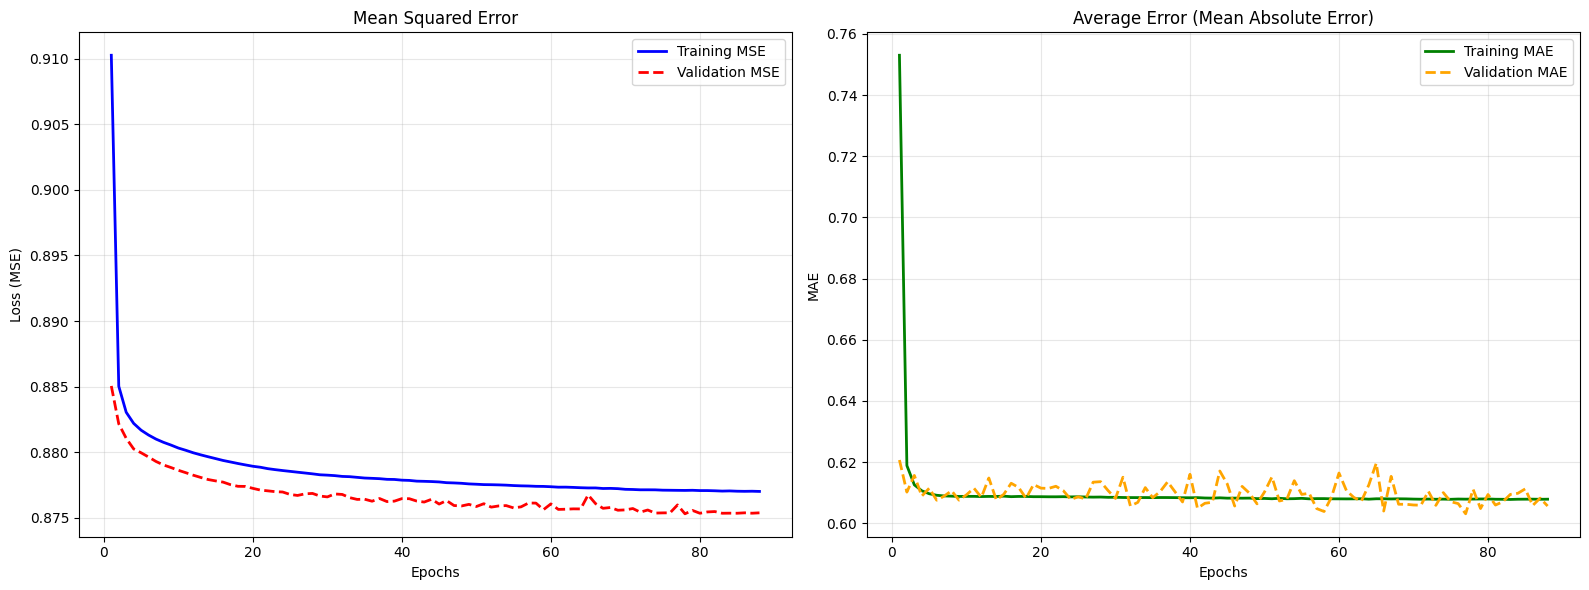

In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    """
    Plots the Training vs Validation Loss (MSE) and MAE.
    Args:
        history: The object returned by model.fit()
    """
    
    # Extract data from the history object
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Extract MAE if you tracked it (your code did: metrics=['mae'])
    mae = history.history.get('mae')
    val_mae = history.history.get('val_mae')
    
    epochs = range(1, len(loss) + 1)

    # Create a figure with 2 subplots side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # --- PLOT 1: MSE (Loss) ---
    axes[0].plot(epochs, loss, 'b-', label='Training MSE', linewidth=2)
    axes[0].plot(epochs, val_loss, 'r--', label='Validation MSE', linewidth=2)
    axes[0].set_title('Mean Squared Error')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss (MSE)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # --- PLOT 2: MAE (Accuracy Metric) ---
    if mae and val_mae:
        axes[1].plot(epochs, mae, 'g-', label='Training MAE', linewidth=2)
        axes[1].plot(epochs, val_mae, 'orange', linestyle='--', label='Validation MAE', linewidth=2)
        axes[1].set_title('Average Error (Mean Absolute Error)')
        axes[1].set_xlabel('Epochs')
        axes[1].set_ylabel('MAE')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
    else:
        axes[1].text(0.5, 0.5, 'MAE not tracked', ha='center')

    plt.tight_layout()
    plt.show()

# --- HOW TO RUN IT ---
# Pass the 'history' variable you got from model.fit()
if 'history' in locals():
    plot_learning_curves(history)
else:
    print("No history found. Make sure you ran: history = model.fit(...)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Target Max: 314.84
Pred Max:   999.00


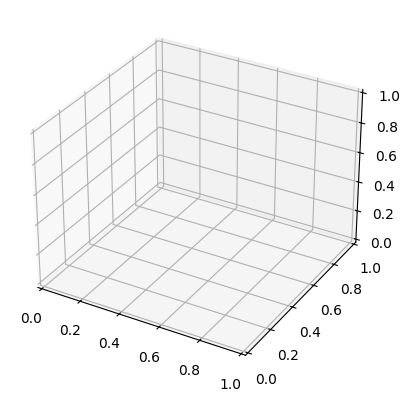

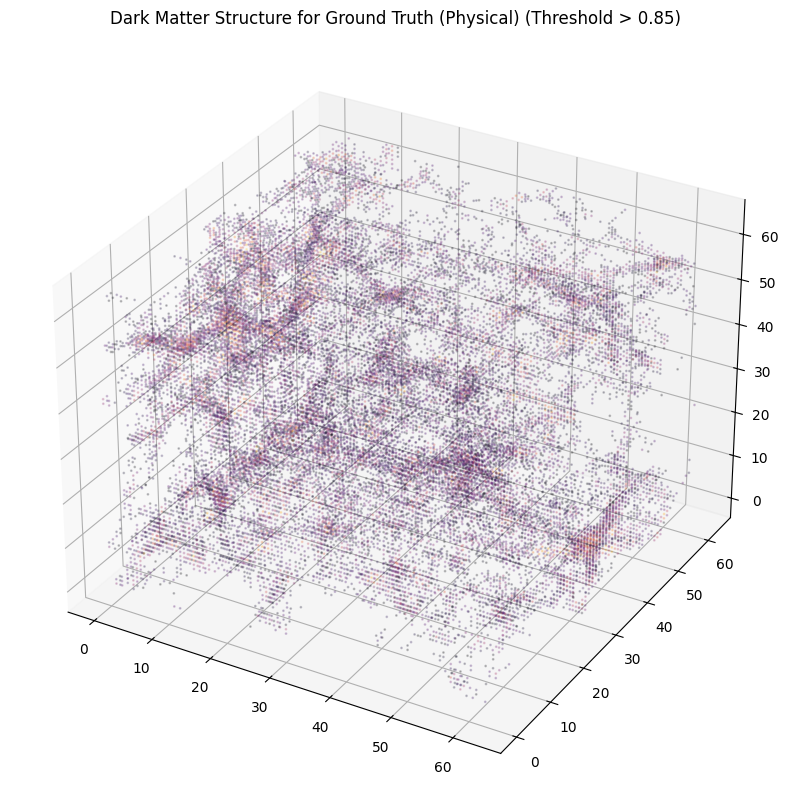

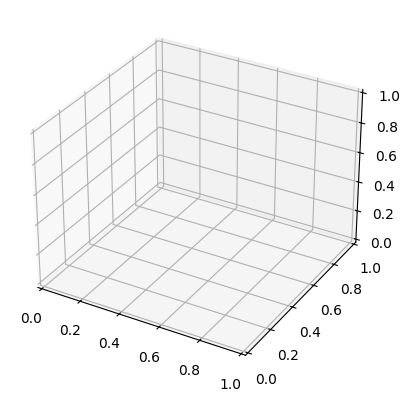

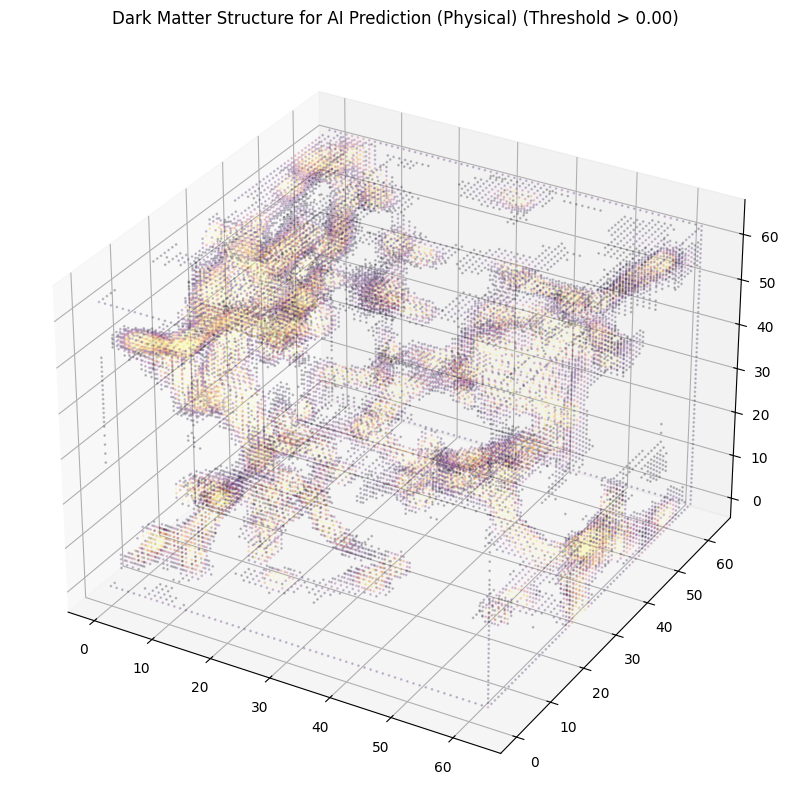

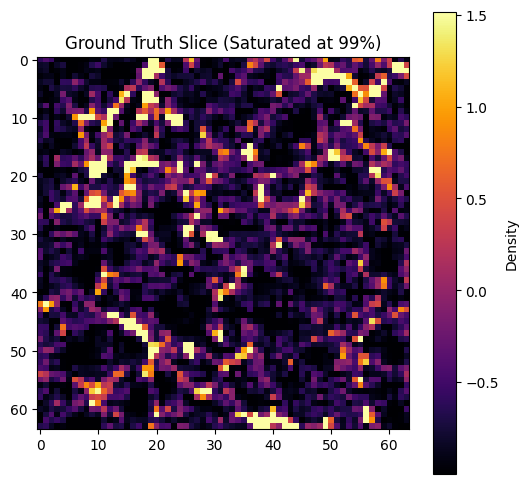

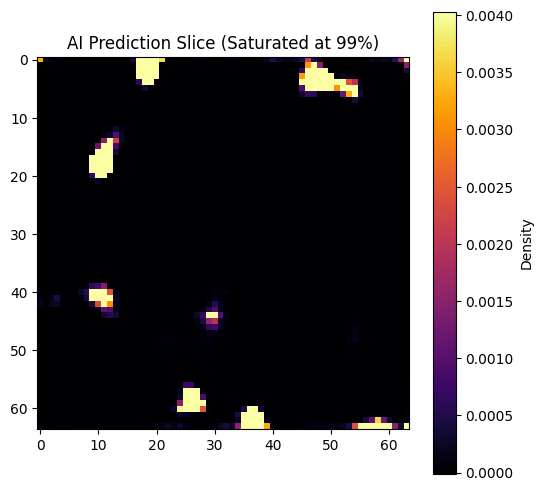

In [ ]:
# 1. Get the batch
batch = list(train_ds.take(1).as_numpy_iterator())[0]
input_batch, target_batch = batch[0], batch[1]

# 2. Get the RAW (Normalized) arrays
raw_target = target_batch[0].squeeze() 
raw_pred   = model.predict(input_batch)[0].squeeze()

# 3. CONVERT BOTH TO PHYSICAL UNITS
# Apply the same un-normalization to the Ground Truth!
phys_target = postprocess_density(raw_target, is_input=False) 
phys_pred   = postprocess_density(raw_pred, is_input=True)

print(f"Target Max: {phys_target.max():.2f}")
print(f"Pred Max:   {phys_pred.max():.2f}")

# 4. Now plot (Apples vs Apples)
# Use the same threshold for both to see a fair comparison
# Calculate threshold from TARGET to see if Prediction captures the same peaks

plot_structure(phys_target, "Ground Truth (Physical)", thresh=90)
plot_structure(phys_pred,   "AI Prediction (Physical)", thresh=90)

plot_slice(phys_target, "Ground Truth Slice")
plot_slice(phys_pred,   "AI Prediction Slice")

In [ ]:
batch = list(val_ds.take(1).as_numpy_iterator())[0]
input_batch, target_batch = batch

raw_target = target_batch[0].squeeze()
raw_pred = model.predict(input_batch)[0].squeeze()

print("=== NORMALIZED SPACE (before postprocessing) ===")
print(f"Ground Truth - Min: {raw_target.min():.4f}, Max: {raw_target.max():.4f}, Mean: {raw_target.mean():.4f}")
print(f"AI Prediction - Min: {raw_pred.min():.4f}, Max: {raw_pred.max():.4f}, Mean: {raw_pred.mean():.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
=== NORMALIZED SPACE (before postprocessing) ===
Ground Truth - Min: -3.6390, Max: 0.7371, Mean: -1.4926
AI Prediction - Min: -1.0000, Max: 1.0000, Mean: -0.9344


In [ ]:
all_preds = []
all_targets = []

for input_batch, target_batch in val_ds.take(10):
    preds = model.predict(input_batch, verbose=0)
    all_preds.append(preds)
    all_targets.append(target_batch.numpy())

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

print(f"Raw Predictions - Min: {all_preds.min():.4f}, Max: {all_preds.max():.4f}")
print(f"Raw Targets - Min: {all_targets.min():.4f}, Max: {all_targets.max():.4f}")

Raw Predictions - Min: -1.0000, Max: 1.0000
Raw Targets - Min: -3.6390, Max: 0.9039


In [ ]:
%pip install --upgrade tf2onnx onnx 

In [ ]:
%pip show tf2onnx

In [ ]:
import tensorflow as tf
import tf2onnx
import onnx


model.save("model_final_newloss.keras")
# 2. Define the input signature (crucial for correct conversion)
# The shape should match your model's expected input shape
# input_signature = [tf.TensorSpec([None, 64, 64, 64, 1], tf.float32, name='input_tensor')] 

# # 3. Convert the model
# onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature, opset=13)

# # 4. Save the ONNX model to a file
# with open("model_final.onnx", "wb") as f:
#     f.write(onnx_model.SerializeToString())